# Qiita ~Uplift Modelingで介入効果を最大化する~¶

In [2]:
import sys

import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

from plotly.offline import iplot

sys.path.append("/home/yuta_saito/notebook/uplift-modeling/")
from causalml.model_selection.metrics import uplift_frame, uplift_bar, uplift_curve, modified_uplift_curve

## データの前処理

In [3]:
# データの読み込み
csv_file = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
df = pd.read_csv(csv_file)

# メールを送らなかった人たちのデータを削除
df = df.loc[df["segment"] != "No E-Mail"].reset_index(drop=True)
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
2,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
3,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
4,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0


In [4]:
# カテゴリカル変数をダミー化
categorical_columns = ["zip_code", "channel"]
dummies = pd.get_dummies(df[categorical_columns], drop_first=True)
df = pd.concat([df.drop(categorical_columns, axis=1), dummies], axis=1)

In [5]:
# 説明変数を分けておく
columns = df.drop(["segment","visit","conversion","spend","history_segment"], axis=1).columns
X = df.drop(["segment","visit","conversion","spend","history_segment"], axis=1).values

In [6]:
# 男性向けメールをtreatment, 女性向けメールをcontrolとする
w = np.array(df.segment == "Mens E-Mail").astype(int)
y = np.array(df.visit == 1).astype(int)

In [7]:
# train, test半分ずつに分ける
X_train, X_test, w_train, w_test, y_train, y_test = train_test_split(X, w, y, test_size=0.5, random_state=0)

# Two-Model Approach (TMA)

In [8]:
# 介入群(treat)と統制群(control)それぞれについてロジスティック回帰モデルで学習
lr_treat = LogisticRegression(C=0.1)
lr_treat.fit(X_train[w_train == 1], y_train[w_train == 1])
lr_control = LogisticRegression(C=0.1)
lr_control.fit(X_train[w_train == 0], y_train[w_train == 0])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
# (介入を受ける場合のサイト訪問確率) / (介入を受けない場合のサイト訪問確率)をuplift_scoreとして算出
proba_treat, proba_control = lr_treat.predict_proba(X_test)[:, 1], lr_control.predict_proba(X_test)[:, 1]
uplift_score = proba_treat / proba_control

## 結果を描画

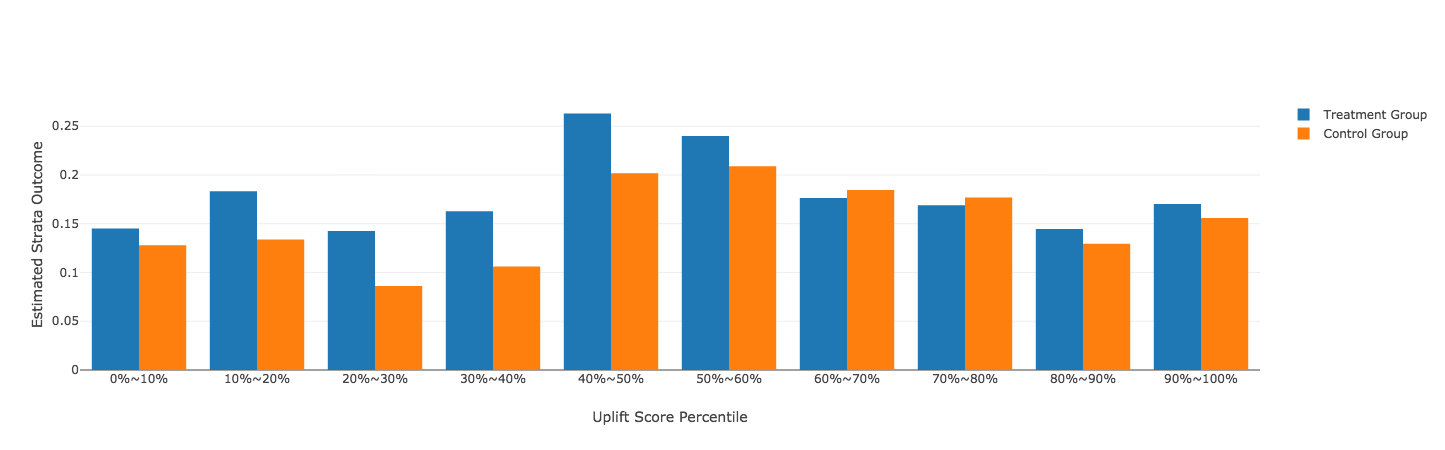

In [10]:
tma_bar = uplift_bar(y_obs=y_test, w=w_test, ite_pred=uplift_score, design="randomized")
iplot(tma_bar)

In [11]:
tma_df = uplift_frame(y_obs=y_test, w=w_test, ite_pred=uplift_score, design="randomized")

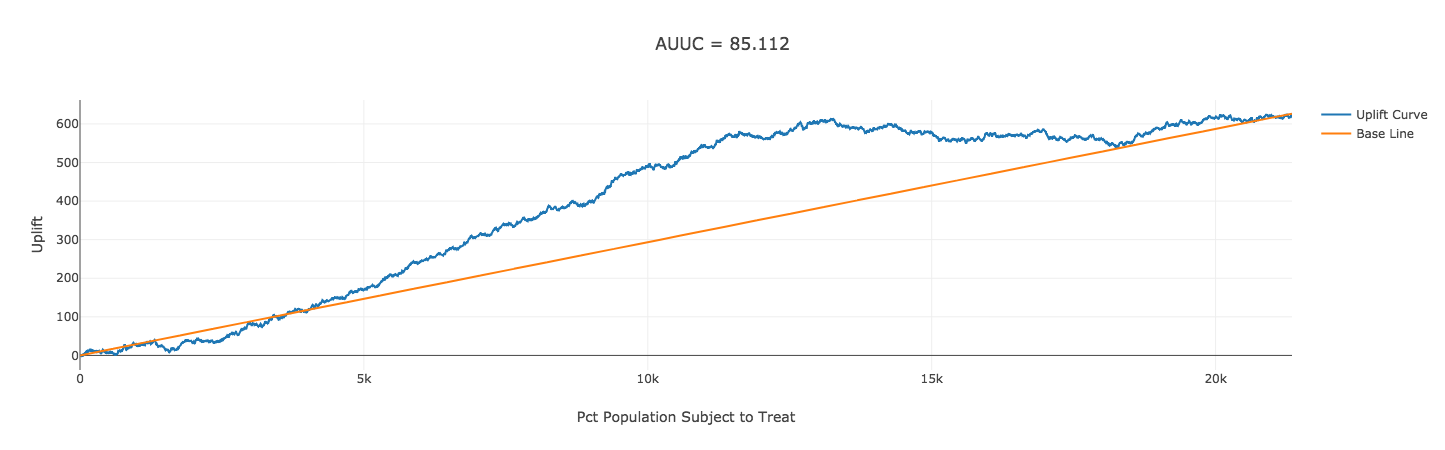

In [12]:
tma_curve = uplift_curve(tma_df)
iplot(tma_curve)

# Class Variable Transformation

In [13]:
# P(G=T) = P(G=C) = 1/2 が成り立っているかを簡単に確認
df[df.segment == "Mens E-Mail"].shape[0] / df.shape[0]

0.49906310020143346

In [14]:
# zラベルを作成
z = w_train * y_train + (1 - w_train) * (1 - y_train)

In [15]:
# Class Variable Transformation
lr_z = LogisticRegression(C=0.1)
lr_z.fit(X_train, z)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
# z sscoreの算出(z-score = 2P(Z=1|X) - 1)
z_score = 2 * lr_z.predict_proba(X_test)[:, 1] - 1

## 結果の描画

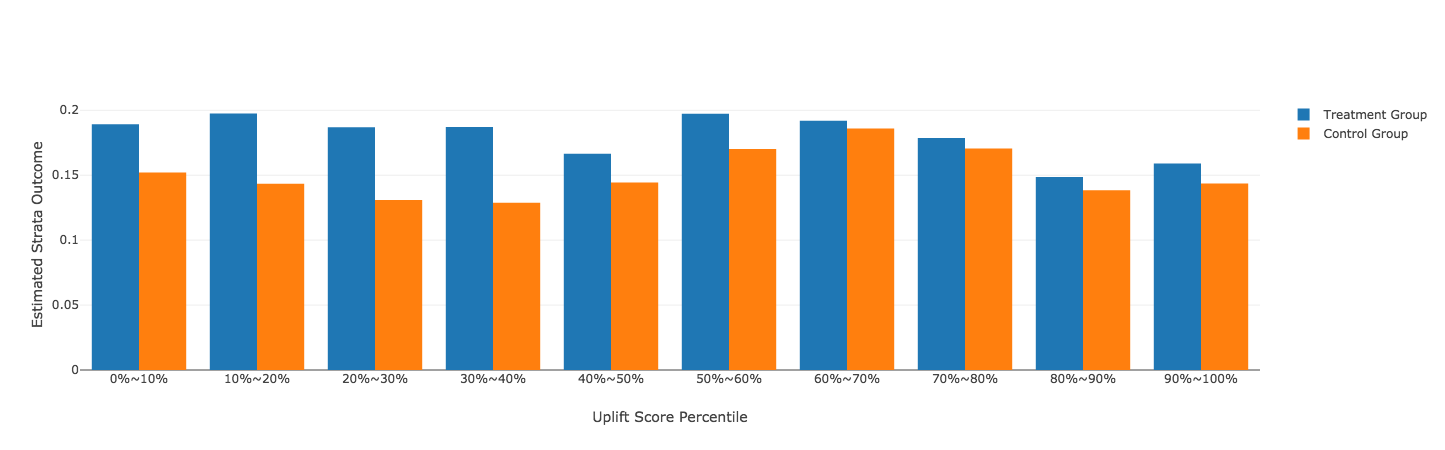

In [17]:
cvt_bar = uplift_bar(y_obs=y_test, w=w_test, ite_pred=z_score, design="randomized")
iplot(cvt_bar)

In [18]:
cvt_df = tma_df = uplift_frame(y_obs=y_test, w=w_test, ite_pred=z_score, design="randomized")

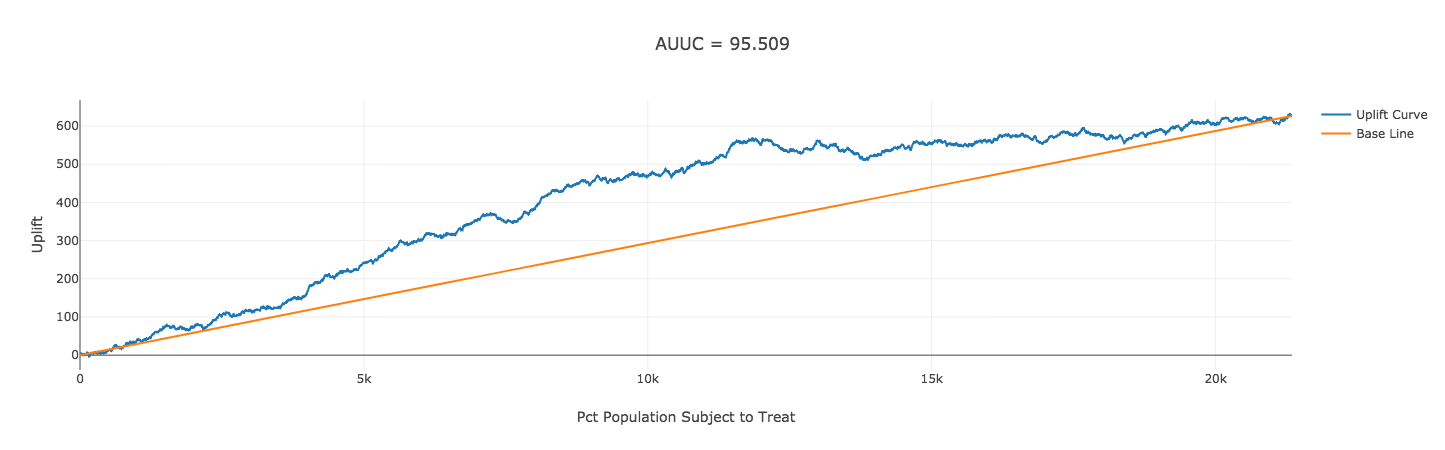

In [19]:
cvt_curve = uplift_curve(tma_df)
iplot(cvt_curve)

In [20]:
# z scoreを算出したロジスティック回帰モデルの係数を表示
for feature, coef in zip(columns, lr_z.coef_[0]):
    print(f"{feature} / {round(coef, 4)}")

recency / -0.0091
history / 0.0001
mens / 0.0804
womens / -0.0487
newbie / -0.0121
zip_code_Surburban / 0.0453
zip_code_Urban / 0.0377
channel_Phone / 0.0401
channel_Web / 0.0137
